In [7]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data, prep_fa_dataset, prep_first_tract_data, prep_fa_flattned_data
from afqinsight.nn.utils import prep_fa_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug
from afqinsight.nn.pt_models import Conv1DAutoencoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




In [3]:
# FA FLATTENED DATASET
# NON VARIATIONAL 
# CONVOLUTIONAL AUTOENCODER
# TESTING LATENT AND DROPOUT SIMULTATENTOUSLY 

In [5]:
import sys 
sys.path.insert(1, '/Users/samchou/AFQ-Insight-Autoencoder-Experiments/AFQ-Insight-Autoencoder-Experiments/Experiment_Utils')
from utils import train_variational_autoencoder, train_autoencoder, select_device
from models import Conv1DVariationalAutoencoder_one_tract_fa

In [6]:
device = select_device()

Using device: mps

Using MPS backend on macOS. (Detailed memory info may not be available.)


In [9]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [10]:
torch_dataset, all_tracts_train_loader, all_tracts_test_loader, all_tracts_val_loader = prep_fa_flattned_data(dataset,batch_size=64)

In [12]:
latent_dims = [2, 4, 8, 16, 32, 64, 100]
dropout_values = [0.0, 0.1, 0.5]
models = {}
results = {}

for dropout in dropout_values:
    for latent_dim in latent_dims:
        print(f"Training Autoencoder with Latent Dimension: {latent_dim} and Dropout: {dropout}")
        
        # Initialize a new autoencoder for each latent dimension
        test_model = Conv1DVariationalAutoencoder_one_tract_fa(latent_dims=latent_dim, dropout=dropout).to(device)
        
        # Train the model 
        training_results = train_variational_autoencoder(model = test_model, train_data=all_tracts_train_loader, val_data=all_tracts_val_loader, epochs = 500, kl_weight=0.001, device = device)
        
        # Store both the model and results
        models[latent_dim, dropout] = test_model
        results[latent_dim, dropout] = training_results
        
        print(f"Completed training for latent_dim={latent_dim}, Best Val RMSE: {training_results['best_val_loss']:.4f}")



Training Autoencoder with Latent Dimension: 2 and Dropout: 0.0


KeyboardInterrupt: 

In [2]:
model_with_latent_8 = models[8, 0.1]

# Visualize a reconstruction
def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        # Get a batch of data
        for x, _ in data_loader:
            # Take just one sample for visualization
            sample = x[0:1, 0:1, :].to(device)
            reconstruction = model(sample)
            
            # Plot the original and reconstruction
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.plot(sample.cpu().numpy()[0, 0, :])
            plt.title("Original")
            
            plt.subplot(1, 2, 2)
            plt.plot(reconstruction.cpu().numpy()[0, 0, :])
            plt.title("Reconstruction")
            
            plt.tight_layout()
            plt.show()
            break

# Visualize a reconstruction from a model with latent dimension 8
for latent_dim in latent_dims:
    visualize_reconstruction(models[latent_dim], val_loader)

NameError: name 'models' is not defined

In [ ]:
# Plot training RMSE vs epoch for each latent dimension
plt.figure(figsize=(12, 6))
for dim in models.keys():
    plt.plot(results[dim]["train_rmse_per_epoch"], label=f"Latent Dim {dim}")
plt.xlabel("Epoch")
plt.ylabel("Training RMSE")
plt.legend()
plt.title("Training RMSE vs Epoch for Different Latent Dimensions")
plt.show()

# Plot validation RMSE vs epoch for each latent dimension
plt.figure(figsize=(12, 6))
for dim in models.keys():
    plt.plot(results[dim]["val_rmse_per_epoch"], label=f"Latent Dim {dim}")
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.legend()
plt.title("Validation RMSE vs Epoch for Different Latent Dimensions")
plt.show()

# Plot best validation loss for each latent dimension
latent_dims = sorted(list(models.keys()))  # Get sorted list of latent dimensions
best_val_losses = [results[dim]["best_val_loss"] for dim in latent_dims]

plt.figure(figsize=(10, 6))
plt.plot(latent_dims, best_val_losses, 'o-')
plt.xlabel("Latent Dimension Size")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs Latent Dimension Size")
plt.grid(True)
plt.show()

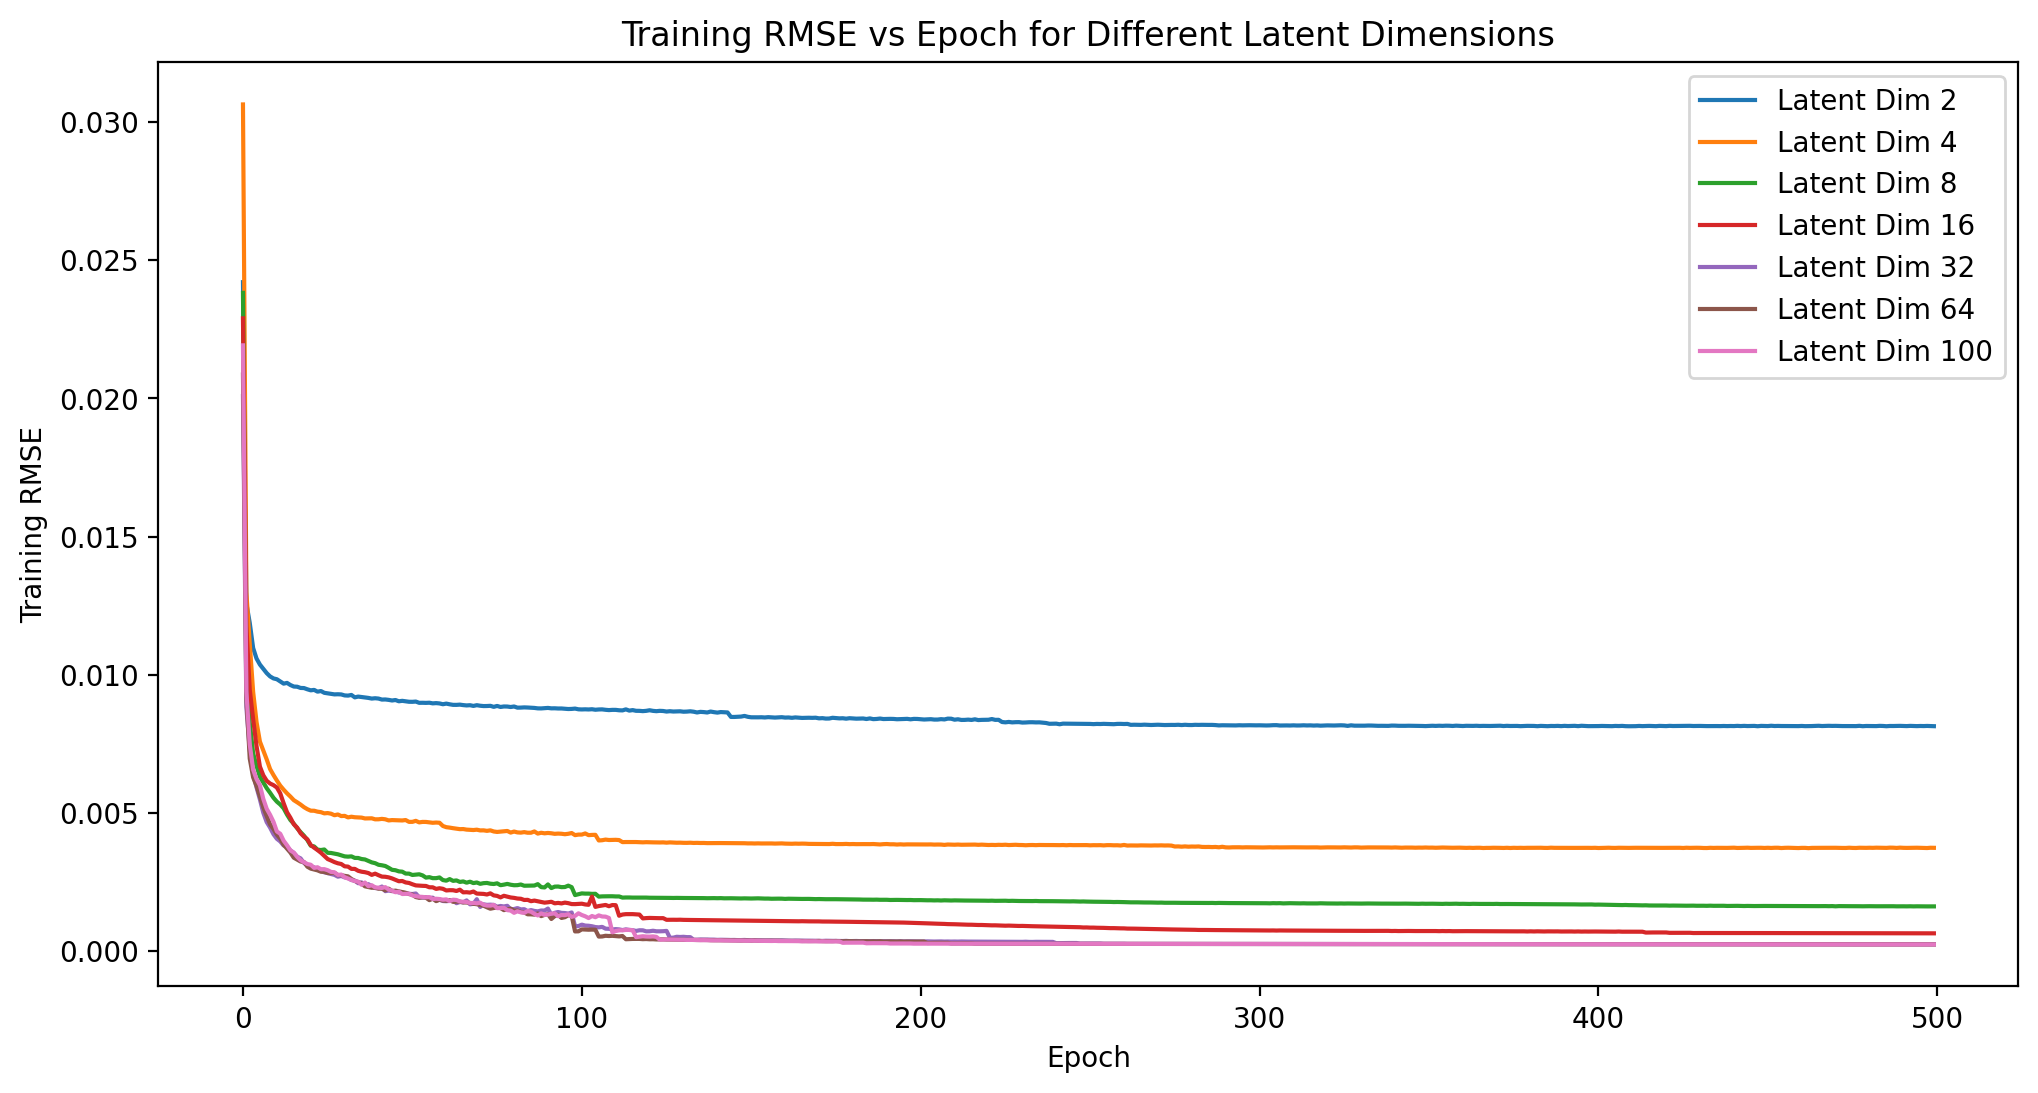

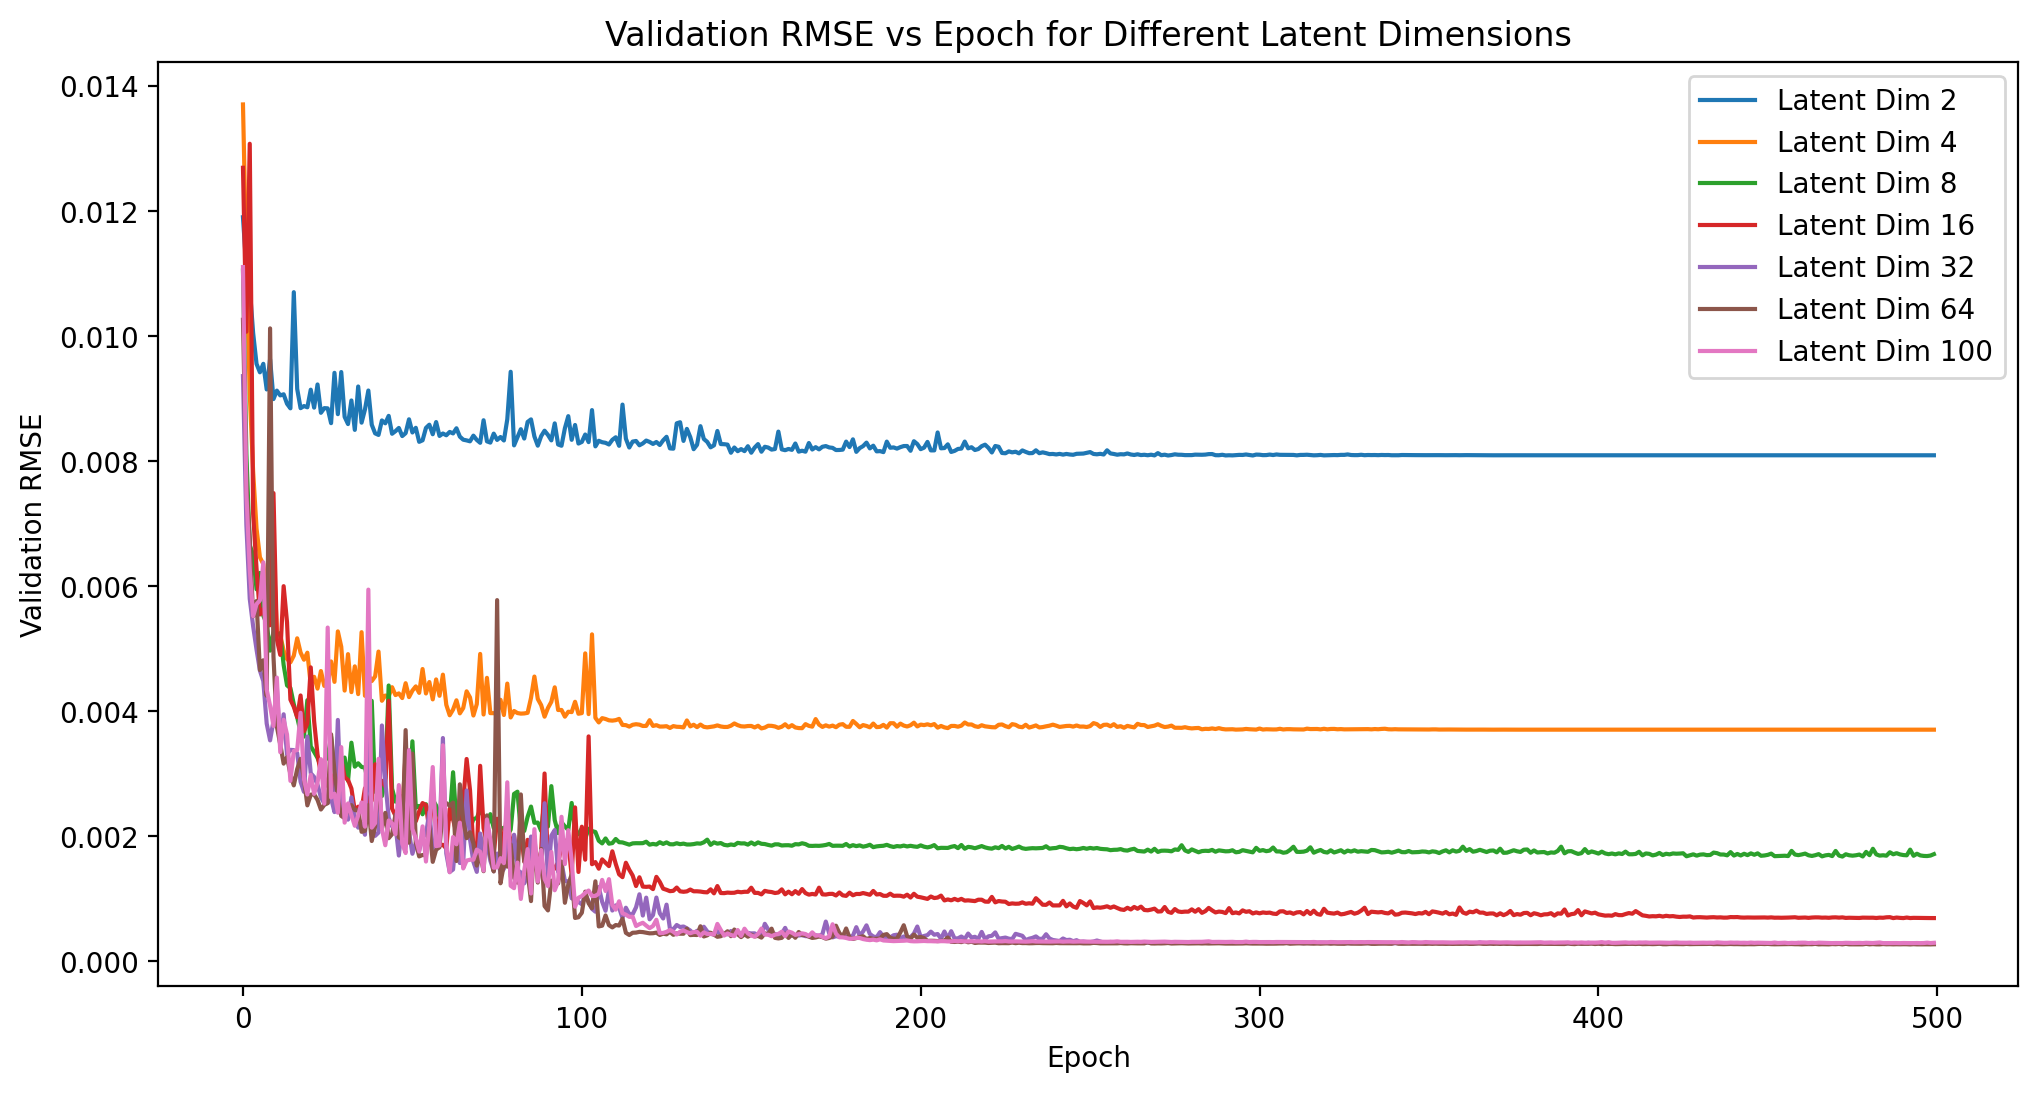

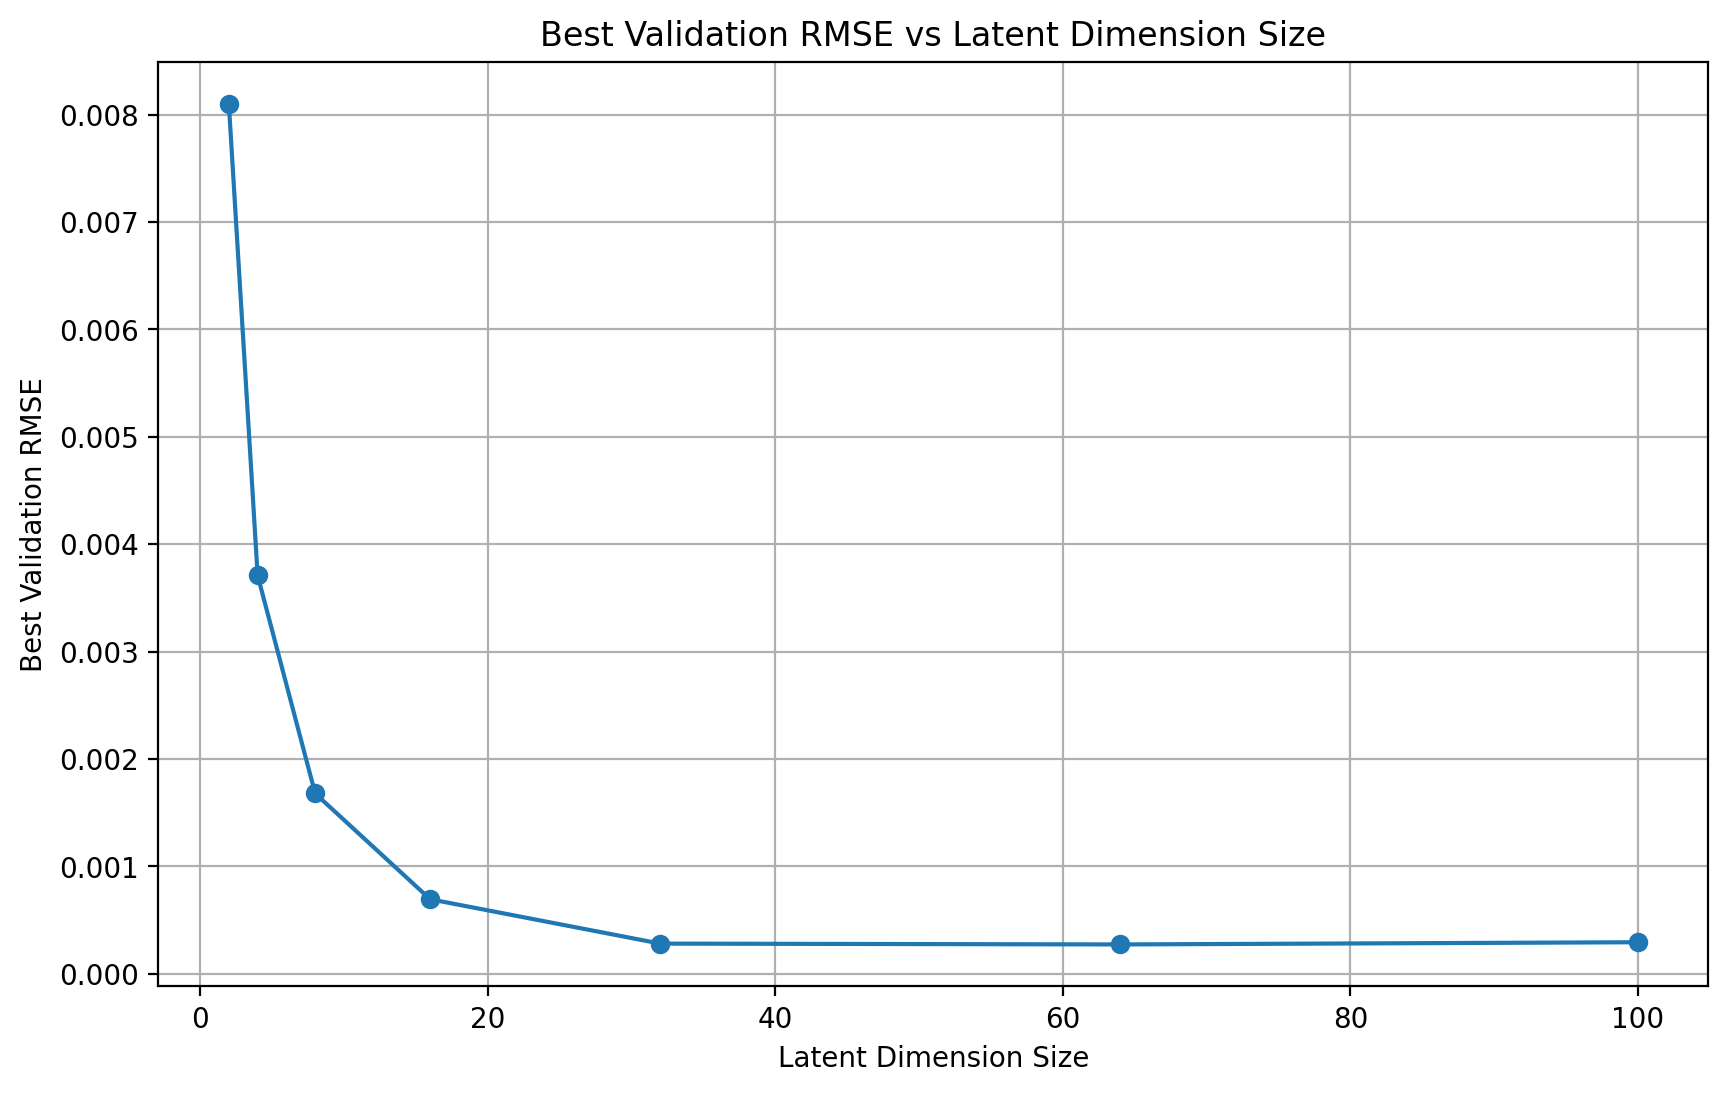

In [15]:
# Create a DataFrame with rows for dropout and columns for latent_dims
df_best_val = pd.DataFrame(index=dropout_values, columns=latent_dims)

# Populate the DataFrame with the best validation RMSE values
for latent_dim in latent_dims:
    for dropout in dropout_values:
         best_val_loss = results[(latent_dim, dropout)]["best_val_loss"]
         df_best_val.loc[dropout, latent_dim] = best_val_loss

# Convert the values to floats (if they aren't already)
df_best_val = df_best_val.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_best_val, annot=True, fmt=".3f", cmap="viridis")
plt.xlabel("Latent Dimensions")
plt.ylabel("Dropout Rate")
plt.title("Best Validation RMSE for Each Dropout and Latent Dimension Combination")
plt.show()
